In [1]:
from dateutil import parser
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import math
import re # used to check if string is a number

# Getting and formatting data

## Constants and helpers

In [2]:
REFERENCE_TIME = datetime(1970,1,1)

MAX_BITSWAP_TIMEOUT = 15000 # 15 seconds

In [3]:
SUCCESS = "SUCCESS"
FAILURE = "FAILURE"
NO_PROVS = "NO_PROVS"
FETCH_FAILED = "FETCH_FAILED"

In [4]:
regex = '^[0-9]+$'
def isNumber(s: str) -> bool:
    return (re.search(regex, s))

### Filenames

In [71]:
# files

data_folder = "data"
plots_folder = "plots"
logs_file = "bitswap.log"

# experiment_20221205  experiment_20221205_packets_20  gatewaycids_10_20221206
experiment = "gatewaycids_10_20221206"

MAX_SAMPLES = 71769

logs_path = data_folder + '/' + experiment + '/' + logs_file

### Loading data

In [72]:
f = open(logs_path, "r")
logs = [l[:-1] if l[-1] == '\n' else l for l in f.readlines()] # remove trailing '\n' if any
f.close()

In [73]:
TIMESTAMP_POS = 0
CID_POS = 1
NPEERS_POS = 2
DIFFERENTIATOR_POS = 3
SUCCESS_PROVIDERS_POS = DIFFERENTIATOR_POS + 1

## Parsing the data

In [74]:
reqs = {}
for line in logs:
    sep = line.split(',')
    req = {}

    req['start'] = parser.parse(sep[TIMESTAMP_POS])
    req['cid'] = sep[CID_POS]
    req['npeers'] = int(sep[NPEERS_POS])
    
    if sep[DIFFERENTIATOR_POS] in [NO_PROVS, FETCH_FAILED]:
        # DHT lookup returned no provider, or selfish bitswap couldn't fetch the block
        req['type'] = sep[DIFFERENTIATOR_POS]
    else:
        if isNumber(sep[DIFFERENTIATOR_POS]):
            # number of milliseconds taken by successfull bitswap request
            providers = sep[SUCCESS_PROVIDERS_POS:]
            req['duration'] = int(sep[DIFFERENTIATOR_POS]) # in milliseconds
            if req['duration'] < MAX_BITSWAP_TIMEOUT:
                req['type'] = SUCCESS
            else:
                # if request took more than 15 seconds, it is a failure
                req['type'] = FAILURE
        else:
            # DHT lookup success and selfish bitswap was able to fetch the block, bitswap failure
            req['type'] = FAILURE
            providers = sep[DIFFERENTIATOR_POS:]
        
        provs = set()
        for p in providers:
            provs.add(p)
        req['providers'] = list(provs)
        
    reqs[req['cid']] = req

    if len(reqs) >= MAX_SAMPLES:
        break

In [75]:
c = 0
for r in reqs:
    if reqs[r]['type'] is FAILURE and 'duration' in reqs[r]:
        c+=1
c

21

In [76]:
min_time

1669635464.755

## Overall statistics

In [77]:
noprovs_count = 0
fetchfailed_count = 0
success_count = 0
failure_count = 0
for r in reqs:
    if reqs[r]['type'] == SUCCESS:
        success_count += 1
    elif reqs[r]['type'] == FAILURE:
        failure_count += 1
    elif reqs[r]['type'] == NO_PROVS:
        noprovs_count += 1
    elif reqs[r]['type'] == FETCH_FAILED:
        fetchfailed_count += 1

In [78]:
print("SUCCESS", success_count)
print("FAILURE", failure_count)
print("NO_PROV", noprovs_count)
print("FETCH FAILED", fetchfailed_count)
print("TOTAL", len(reqs))
print("Overall success rate", str(round(100*success_count/(success_count+failure_count), 2))+"% (within",
    int(MAX_BITSWAP_TIMEOUT/1000), "seconds)")
print("Available content rate", str(round(100*(success_count+failure_count)/len(reqs), 2))+"%")

SUCCESS 30936
FAILURE 54
NO_PROV 1134
FETCH FAILED 280
TOTAL 32404
Overall success rate 99.83% (within 15 seconds)
Available content rate 95.64%


## Providers stats

In [79]:
bitswap_provider_score = {}
for cid in reqs:
    if reqs[cid]['type'] == SUCCESS:
        for p in reqs[cid]['providers']:
            if p not in bitswap_provider_score:
                bitswap_provider_score[p] = 1
            else:
                bitswap_provider_score[p] += 1
# order the list
bitswap_provider_score = {key: val for key, val in sorted(bitswap_provider_score.items(), key = lambda ele: ele[1], reverse = True)}

In [80]:
i = 0
for cid in list(bitswap_provider_score)[:10]:
    i += 1
    print(str(i)+'.', cid, ':', bitswap_provider_score[cid])

1. 12D3KooWGtRcWvihm4hX2gT6bQu3uyjb78rgyQR3hPhkxMwivscY : 1864
2. 12D3KooWGRJo1vLDBtfS8a4cVss2QVqvbCaPgtmwwgpUtW675QRa : 1663
3. 12D3KooWLsSWaRsoCejZ6RMsGqdftpKbohczNqs3jvNfPgRwrMp2 : 1589
4. 12D3KooWAuMTLB3XF8MJKRLqNxZF5cTjHP29LrhCzsr5rAqvRXHG : 1561
5. 12D3KooWRZ1Vj1UYrCdZDKz1sTPW5xSG88Ef7HHaawN14CqPBfWv : 1267
6. 12D3KooWJc7GbwkjVg9voPNxdRnmEDS3i8NXNwRXD6kLattaMnE4 : 1164
7. 12D3KooWJ59N9z5CyLTtcUTnuTKnRTEVxiztijiEAYbP16aZjQ3D : 1111
8. 12D3KooWPjSUkcASDEed45e3EnGGoDtAMg9ipssdwyrUC2FXHhjZ : 955
9. 12D3KooWEGeZ19Q79NdzS6CJBoCwFZwujqi5hoK8BtRcLa48fJdu : 833
10. 12D3KooWKd92H37a8gCDZPDAAGTYvEGAq7CNk1TcaCkcZedkTwFG : 707


In [81]:
top_n_peers_vals = [1, 3, 5, 10, 20, 50, int(len(bitswap_provider_score)/2), len(bitswap_provider_score)]
for n in top_n_peers_vals:
    s = 0
    c = 0
    for peerid in bitswap_provider_score:
        if c == n:
            break
        c += 1
        s += bitswap_provider_score[peerid]
    print("Top", n, "peers serve " + str(round(100*s/success_count,2))+"% of the successful bitswap requests")

Top 1 peers serve 6.03% of the successful bitswap requests
Top 3 peers serve 16.54% of the successful bitswap requests
Top 5 peers serve 25.68% of the successful bitswap requests
Top 10 peers serve 41.1% of the successful bitswap requests
Top 20 peers serve 54.86% of the successful bitswap requests
Top 50 peers serve 74.2% of the successful bitswap requests
Top 224 peers serve 98.19% of the successful bitswap requests
Top 449 peers serve 100.0% of the successful bitswap requests


## All requests (SUCCESS + FAILURE)

In [82]:
all_bitswap_provider_score = {}
for cid in reqs:
    if reqs[cid]['type'] in [SUCCESS, FAILURE]:
        for p in reqs[cid]['providers']:
            if p not in all_bitswap_provider_score:
                all_bitswap_provider_score[p] = 1
            else:
                all_bitswap_provider_score[p] += 1
# order the list
all_bitswap_provider_score = {key: val for key, val in sorted(all_bitswap_provider_score.items(), key = lambda ele: ele[1], reverse = True)}

In [83]:
i = 0
for cid in list(all_bitswap_provider_score)[:10]:
    i += 1
    print(str(i)+'.', cid, ':', all_bitswap_provider_score[cid])

1. 12D3KooWGtRcWvihm4hX2gT6bQu3uyjb78rgyQR3hPhkxMwivscY : 1864
2. 12D3KooWGRJo1vLDBtfS8a4cVss2QVqvbCaPgtmwwgpUtW675QRa : 1663
3. 12D3KooWLsSWaRsoCejZ6RMsGqdftpKbohczNqs3jvNfPgRwrMp2 : 1590
4. 12D3KooWAuMTLB3XF8MJKRLqNxZF5cTjHP29LrhCzsr5rAqvRXHG : 1561
5. 12D3KooWRZ1Vj1UYrCdZDKz1sTPW5xSG88Ef7HHaawN14CqPBfWv : 1272
6. 12D3KooWJc7GbwkjVg9voPNxdRnmEDS3i8NXNwRXD6kLattaMnE4 : 1164
7. 12D3KooWJ59N9z5CyLTtcUTnuTKnRTEVxiztijiEAYbP16aZjQ3D : 1111
8. 12D3KooWPjSUkcASDEed45e3EnGGoDtAMg9ipssdwyrUC2FXHhjZ : 955
9. 12D3KooWEGeZ19Q79NdzS6CJBoCwFZwujqi5hoK8BtRcLa48fJdu : 833
10. 12D3KooWKd92H37a8gCDZPDAAGTYvEGAq7CNk1TcaCkcZedkTwFG : 707


In [84]:
top_n_peers_vals = [1, 3, 5, 10, 20, 50, int(len(all_bitswap_provider_score)/2), len(all_bitswap_provider_score)]
for n in top_n_peers_vals:
    s = 0
    c = 0
    for peerid in all_bitswap_provider_score:
        if c == n:
            break
        c += 1
        s += all_bitswap_provider_score[peerid]
    print("Top", n, "peers serve " + str(round(100*s/(success_count+failure_count),2))+"% of the successful bitswap requests")

Top 1 peers serve 6.01% of the successful bitswap requests
Top 3 peers serve 16.51% of the successful bitswap requests
Top 5 peers serve 25.65% of the successful bitswap requests
Top 10 peers serve 41.05% of the successful bitswap requests
Top 20 peers serve 54.81% of the successful bitswap requests
Top 50 peers serve 74.11% of the successful bitswap requests
Top 225 peers serve 98.14% of the successful bitswap requests
Top 450 peers serve 100.0% of the successful bitswap requests


# Plots

## Latencies distribution

In [85]:
success_time_distrib = []
for cid in reqs:
    if reqs[cid]['type'] == SUCCESS:
        success_time_distrib.append(reqs[cid]['duration'])

In [86]:
def bin_plot(data, n_bins=50, start=None, end=None, additional=False, nticks=None, interticks=None, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # data is a list of values
    # n_bins is the number of bins to display
    # start is the first bin on the xaxis (left)
    # end is the last bin on the yaxis (right)
    # additional=True adds a last bin (making the result visually more pleasant)

    # all time is in ms
    
    # define start and end
    if start is None:
        start = min(data)
    if end is None:
        end = max(data)
    
    # define interval between each bin
    interval = (end-start) / n_bins

    x_range = end-start
    divisor = 0
    if nticks is not None and x_range % nticks == 0:
        divisor = nticks
    else:
        for i in [8, 5, 6, 9, 7, 10, 12, 4, 3, 11]:
            if x_range % i == 0:
                divisor = i
                break
    
    mult = int(x_range / divisor)
    xticks = [start+(i*mult) for i in range(divisor+1)]

    def common_div(labels: list, divisors: list) -> list:
        for l in labels:
            if l % divisors[0] != 0:
                return labels
        new_labels = [int(l/divisors[0]) for l in labels]
        if len(divisors) == 1:
            return new_labels
        else:
            return common_div(new_labels, divisors[1:])

    labels = common_div(xticks, [1000, 60, 60, 24, 7]) # ms/s, s/min, min/h, h/day, day/week

    inter_ticks_candidates = [3]
    if interticks is not None:
        inter_ticks_candidates = [interticks] + inter_ticks_candidates
    for i in inter_ticks_candidates:
        if mult % i == 0:
            delta = int(mult/i)
            xticks = [xticks[int(x/i)]+(x%i)*delta for x in range(i*(len(xticks)-1)+1)]
            labels = [labels[int(l/i)] if l%i == 0 else '' for l in range(i*(len(labels)-1)+1)]
            break

    # add the additional last bin
    if additional:
        end += interval
        n_bins += 1
        
    # generate the bins
    bins = [0 for _ in range(n_bins)] # create n_bins bins

    # iterate on data and classify it into the bins
    for d in data:
        if start <= d < end:
            b = int((d-start)/interval)
            bins[b] += 1
        elif d == end:
            # corner case, if some value IS the end, round it to the previous bin
            bins[-1] += 1
    
    # xaxis scale
    xs = [start + i*interval for i in range(n_bins)]
    
    # width of each bar
    width = 0.8 * interval
    
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    
    # bar plot the data
    plt.bar(xs, bins, width=width)

    plt.xticks(ticks=xticks, labels=labels)
    
    # set the grid
    plt.grid()
    
    # samples occupies ~ 1/5 of the space
    samples_ypos = max(bins)/2
    # if a bin among the last 1/5 of the x space is higher than 1/2 max(bin)
    # raise the samples_ypos to 110% of this value
    if max(bins[-int(n_bins/5):]) > samples_ypos:
        samples_ypos = max(bins[-int(n_bins/5):])*1.1
    plt.text(0.95*end, samples_ypos, "Samples: "+str(sum(bins)), ha='right')
    
    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    
    # export to file
    if filename is not None:
        plt.savefig(plots_folder+'/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()

In [87]:
limits = [100, 150, 200, 500, 1000, 5000, 15000]
success_time_distrib_buckets = [0 for _ in limits]
for t in success_time_distrib:
    if t > limits[-1]:
        print(t)
    i = 0
    while limits[i] < t:
        i += 1
    success_time_distrib_buckets[i] += 1

for i in range(len(limits)):
    print("Under "+str(limits[i])+"ms: "+str(round(100*sum(success_time_distrib_buckets[:i+1])/len(success_time_distrib), 2))+"%")

Under 100ms: 43.59%
Under 150ms: 56.82%
Under 200ms: 64.02%
Under 500ms: 81.94%
Under 1000ms: 90.44%
Under 5000ms: 98.69%
Under 15000ms: 100.0%


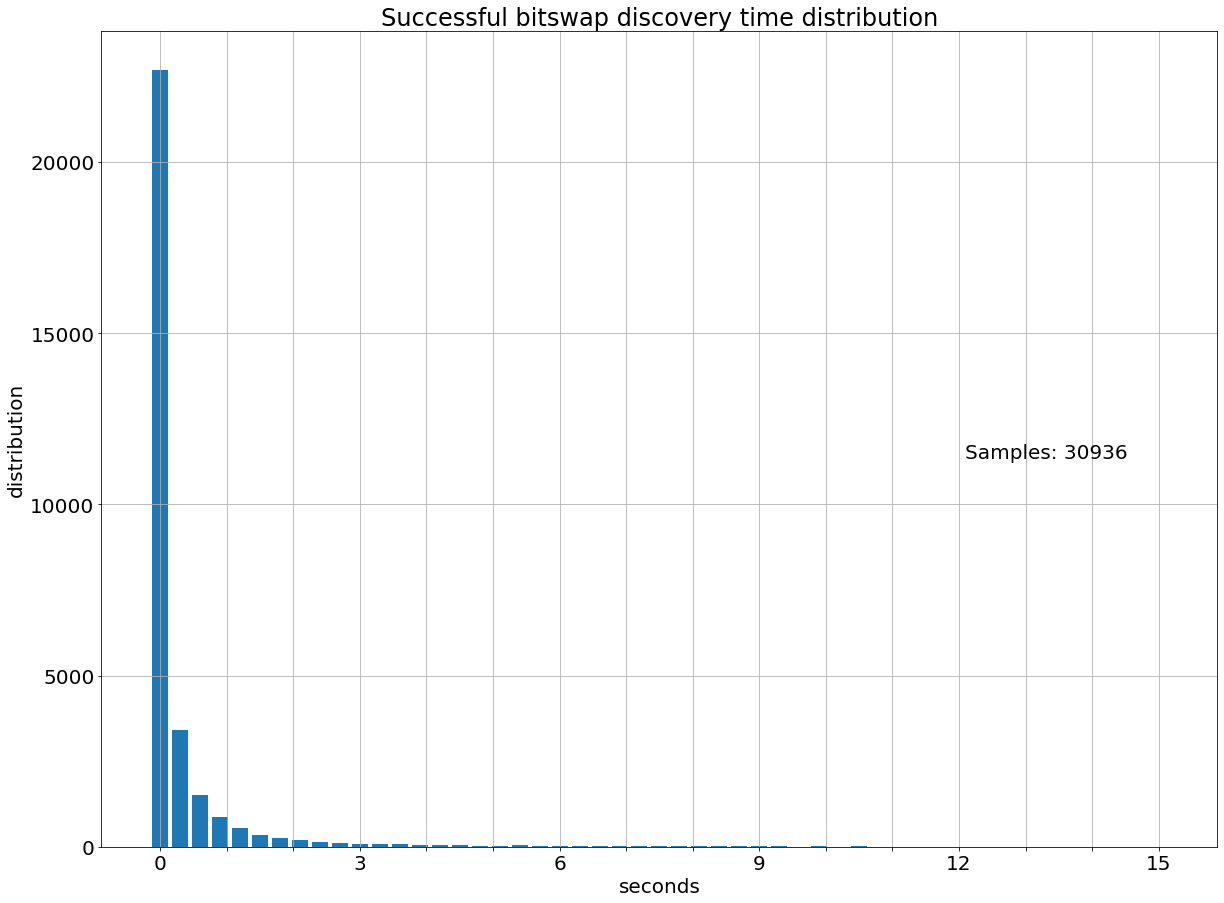

In [88]:
bin_plot(success_time_distrib, start=0, end=15000, n_bins=50, additional=True, nticks=5, title="Successful bitswap discovery time distribution", xaxis_label="seconds", yaxis_label="distribution", filename="success-rate-15s-"+experiment+".png")


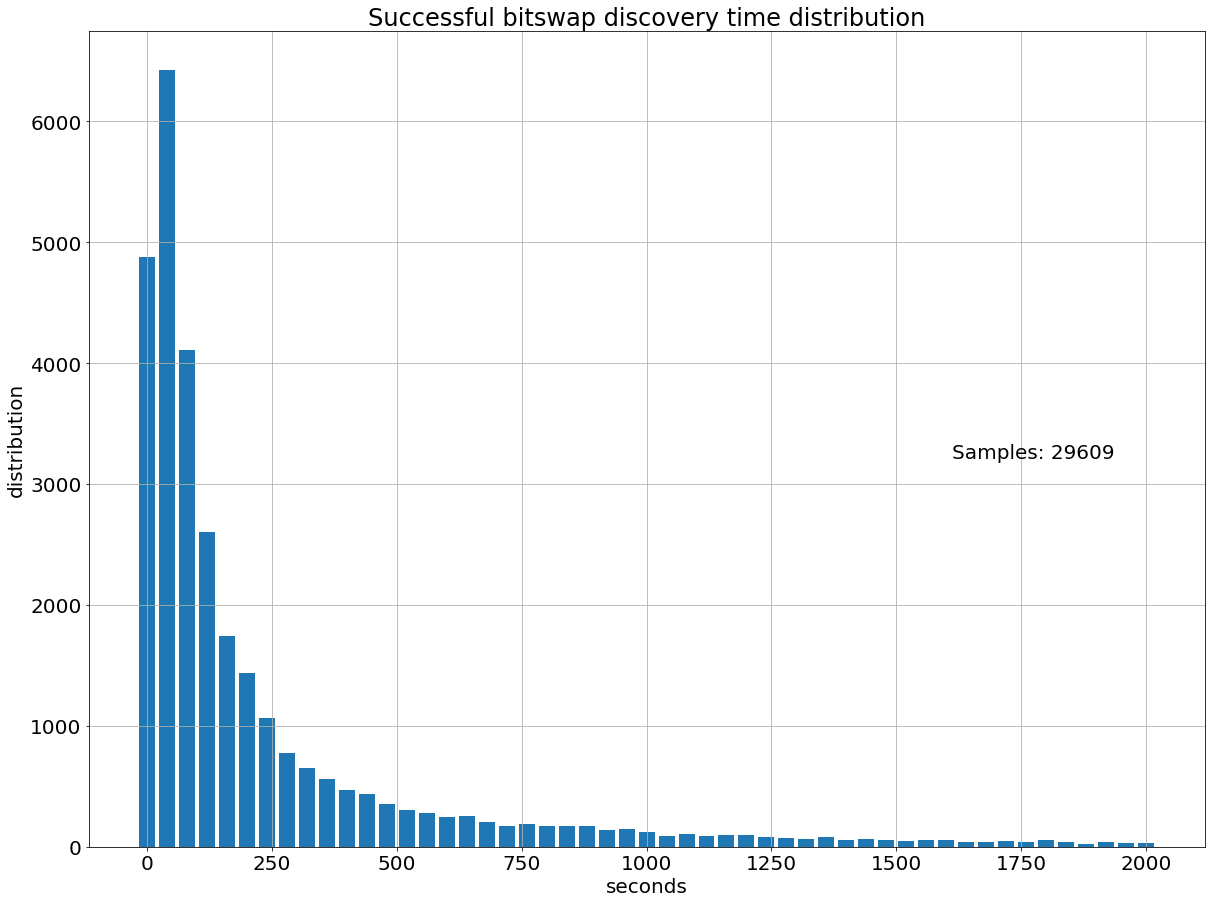

In [89]:
bin_plot(success_time_distrib, start=0, end=2000, n_bins=50, additional=True, nticks=8, title="Successful bitswap discovery time distribution", xaxis_label="seconds", yaxis_label="distribution")


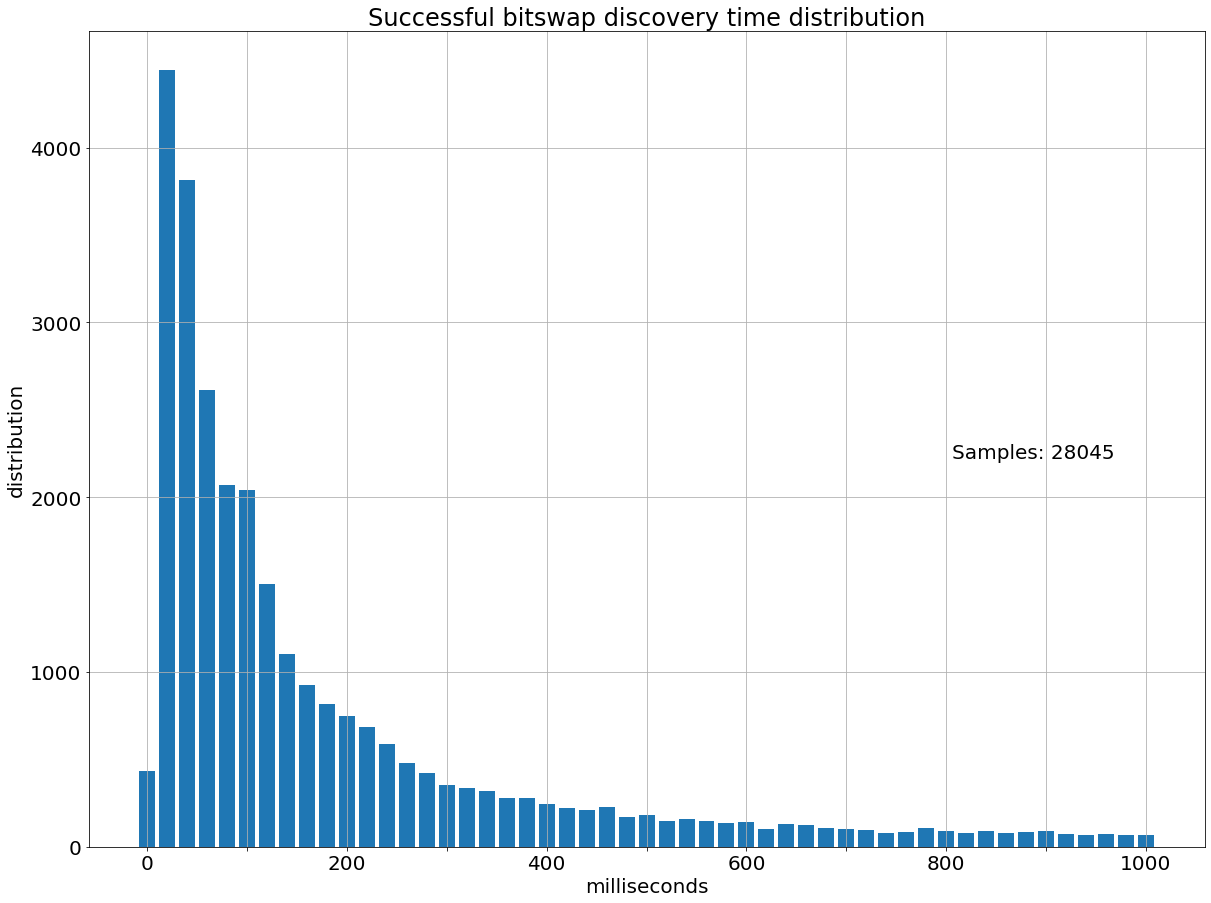

In [90]:
bin_plot(success_time_distrib, start=0, end=1000, n_bins=50, additional=True, nticks=5, interticks=2, title="Successful bitswap discovery time distribution", xaxis_label="milliseconds", yaxis_label="distribution", filename="success-rate-1s-"+experiment+".png")


## Latencies CDF

In [91]:
def line_plot(data, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    
    # bar plot the data
    ax.plot(data, lw=4)

    xs = range(0, len(data), 100)
    plt.xticks(ticks=xs, labels=[int(x/100) for x in xs])
        
    # set the grid
    plt.grid()

    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    # export to file
    if filename is not None:
        plt.savefig(plots_folder+'/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()

In [92]:
# cdf
intervals = 10 # in ms
success_distrib_cdf = [0 for _ in range(int(MAX_BITSWAP_TIMEOUT/intervals)+1)]

for t in success_time_distrib:
    b = int(t/intervals)
    for i in range(b, len(success_distrib_cdf)):
        success_distrib_cdf[i] += 1
for i in range(len(success_distrib_cdf)):
    success_distrib_cdf[i] /= len(success_time_distrib)

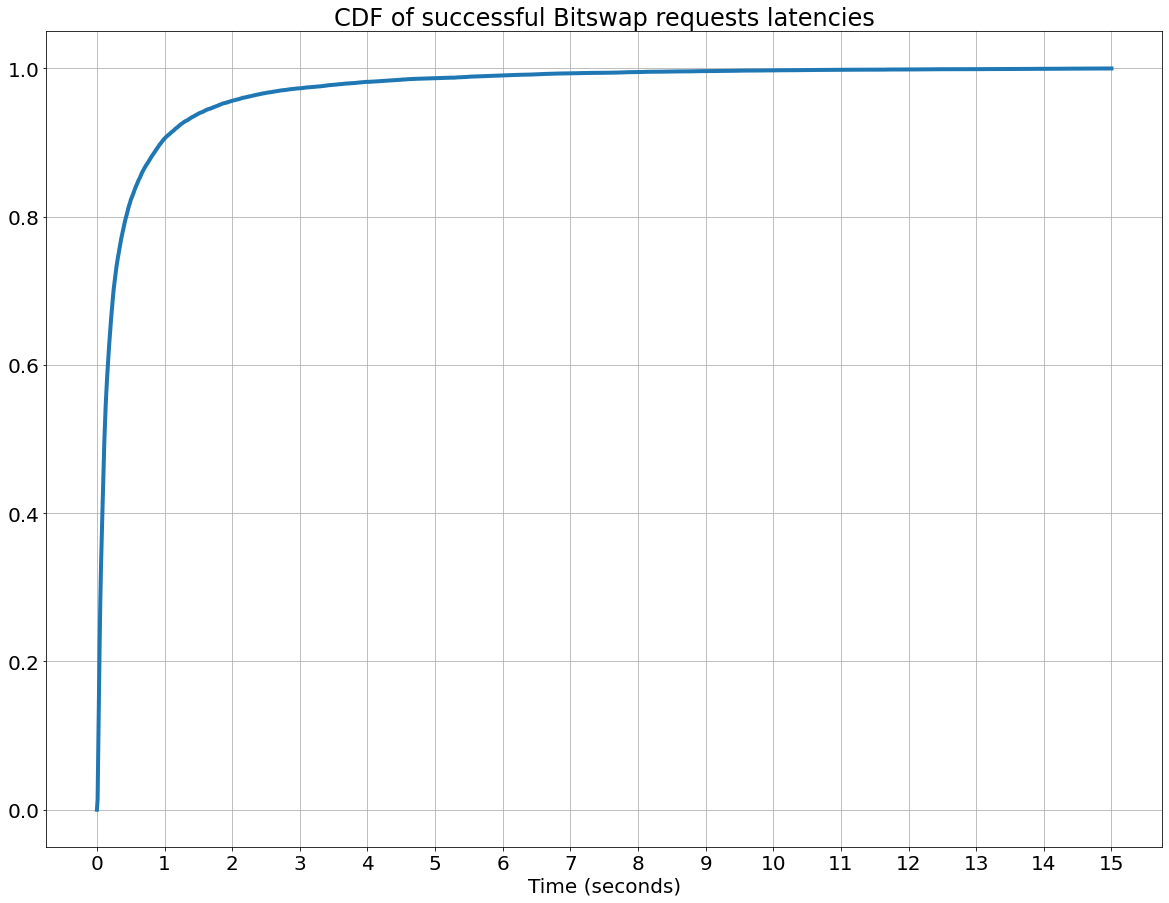

In [93]:
line_plot(success_distrib_cdf, title="CDF of successful Bitswap requests latencies", xaxis_label="Time (seconds)", filename="cdf-latencies-"+experiment+".png")

In [94]:
def line_plot_2(data, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    
    # bar plot the data
    ax.plot(data, lw=4)

    xs = range(0, len(data), 20)
    plt.xticks(ticks=xs, labels=[10*x for x in xs])
        
    # set the grid
    plt.grid()

    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    # export to file
    if filename is not None:
        plt.savefig(plots_folder+'/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()

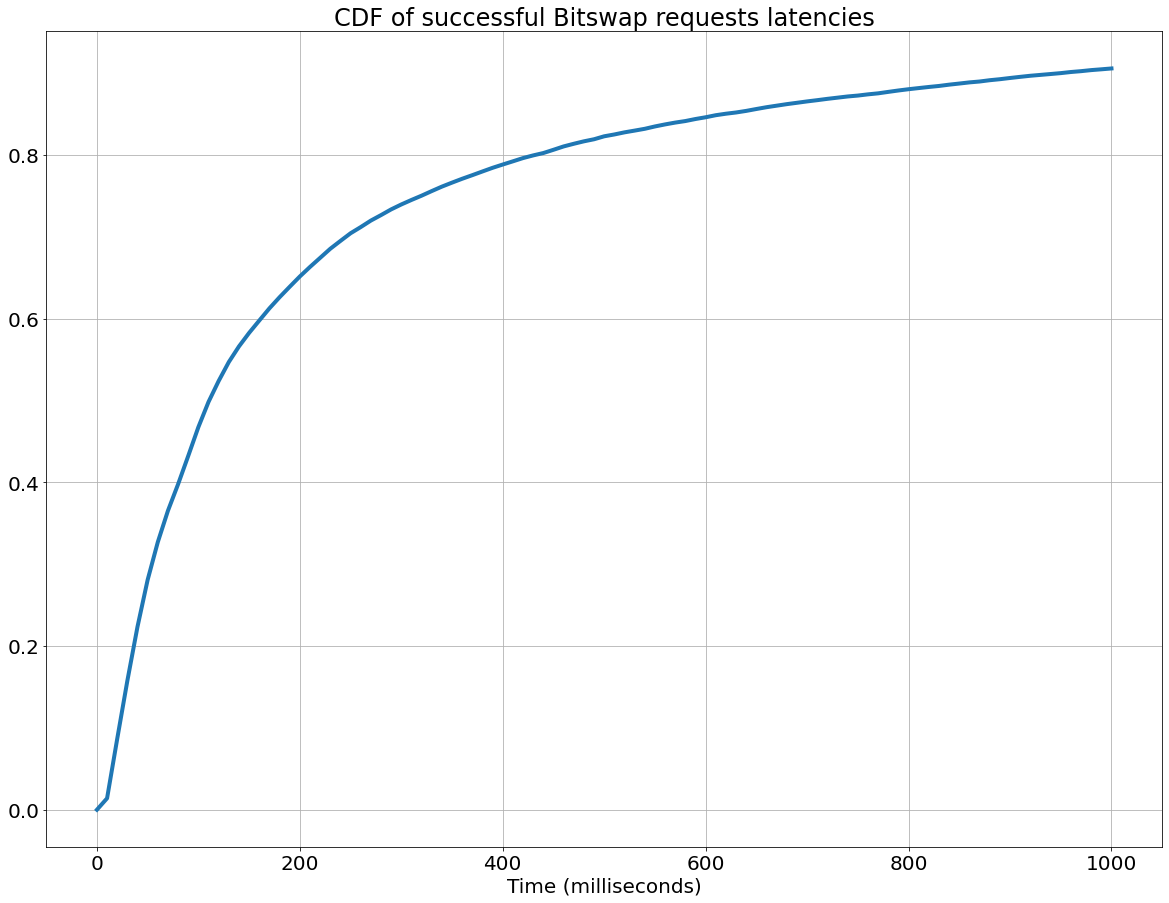

In [95]:
line_plot_2(success_distrib_cdf[:int(1+len(success_distrib_cdf)/15)], title="CDF of successful Bitswap requests latencies", xaxis_label="Time (milliseconds)", filename="cdf-latencies-1s-"+experiment+".png")

## Number of directly connected peers over time

In [96]:
def boxplot_time(data, hours=None, n_bins=None, start=None, end=None, duration=None, additional=False, title=None,
        xaxis_label=None, yaxis_label=None, filename=None):
    # data is a list of tuples [value(time), value]
    # n_bins is the number of bins to display
    # start is the first bin on the xaxis (left)
    # end is the last bin on the yaxis (right)
    # additional=True adds a last bin (making the result visually more pleasant)
    
    # TODO
    # range of bins (e.g 20-50)
    # given this range, and the difference between start and end, define a number of bins
    # fitting an integer number of hours, close to end, and drop the last part
    # This allow us to have "round" numbers of the plots, adjusting according to the
    # experiment duration
    
    times = [x[0] for x in data]
    
    # define start and end
    duration_from_end = False
    if duration is not None and start is None and end is not None:
        duration_from_end = True

    if start is None:
        start = min(times)
    if end is None:
        end = max(times)

    print((end-start)/60/60)

    if duration_from_end:
        start = end - duration
    elif duration is not None:
        end = start + duration
            
    # define interval between each bin
    interval = (end-start) / n_bins

    # add the additional last bin
    if additional:
        end += interval
        n_bins += 1
        
    # generate the bins
    bins = [[] for _ in range(n_bins)] # create n_bins bins

    # iterate on data and classify it into the bins
    for d in data:
        if start <= d[0] < end:
            b = int((d[0]-start)/interval)
            bins[b].append(d[1])
        elif d[0] == end:
            # corner case, if some value IS the end, round it to the previous bin
            bins[-1].append(d[1])
    
    x_scale = 60*60 # from seconds to hours
    # xaxis scale
    xs = [int(i*interval/x_scale) for i in range(n_bins)]
    print(interval, xs, x_scale)
    # width of each bar
    width = 0.8 * interval / x_scale
    
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    
    # bar plot the data
    ax.boxplot(bins, widths=width, positions=xs)
        
    # set the grid
    plt.grid()
    
    # samples occupies ~ 1/5 of the space
    #samples_ypos = max(bins)/2
    # if a bin among the last 1/5 of the x space is higher than 1/2 max(bin)
    # raise the samples_ypos to 110% of this value
    #if max(bins[-int(n_bins/5):]) > samples_ypos:
    #    samples_ypos = max(bins[-int(n_bins/5):])*1.1
    #plt.text(0.95*end, samples_ypos, "Samples: "+str(sum(bins)), ha='right')
    
    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    
    # export to file
    if filename is not None:
        plt.savefig(plots_folder+'/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()

In [97]:
time_npeers = []
for cid in reqs:
    if reqs[cid]['type'] in [SUCCESS, FAILURE]:
        time_npeers.append((reqs[cid]['start'].timestamp(), reqs[cid]['npeers']))

1.7506102777851953
7200.0 [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48] 3600


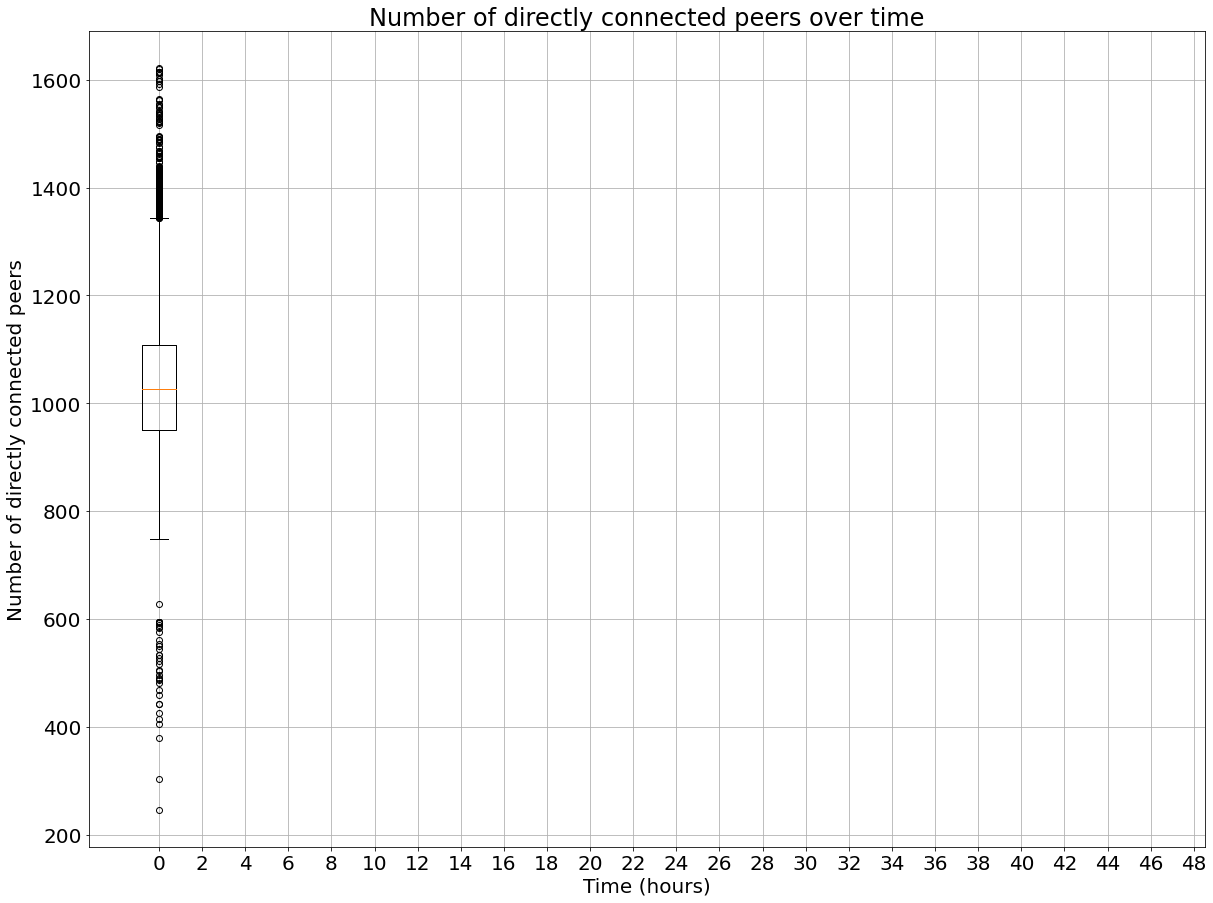

In [98]:
boxplot_time(time_npeers, n_bins=24, duration=48*60*60, additional=True, title="Number of directly connected peers over time", xaxis_label="Time (hours)", yaxis_label="Number of directly connected peers", filename="connected-peers-"+experiment+".png") # duration in seconds

## Success rate over time

In [99]:
# Get min and max times recorded for the experiment
min_time = datetime(year=2100, month=1, day=1).timestamp()
max_time = datetime(year=1970, month=1, day=1).timestamp()
for cid in reqs:
    if reqs[cid]['type'] in [SUCCESS, FAILURE]:
        if reqs[cid]["start"].timestamp() > max_time:
            max_time = reqs[cid]["start"].timestamp()
        if reqs[cid]["start"].timestamp() < min_time:
            min_time = reqs[cid]["start"].timestamp()

In [100]:
print(min_time, max_time, max_time-min_time)

1670253823.338 1670260125.535 6302.197000026703


In [101]:
success_rate_time_interval = 4*60*60 # in seconds
n_bins_time = int((max_time-min_time)/success_rate_time_interval) + 1

In [102]:
def success_ratio_time_interval(success_rate_time_interval, max_time_interval): # in seconds
    n_bins_time = int((max_time-min_time)/success_rate_time_interval) + 1
    bins_time = [{SUCCESS: 0, FAILURE: 0} for _ in range(n_bins_time)]
    bins_conns_time = [[] for _ in range(n_bins_time)]
    for cid in reqs:
        if max_time_interval is not None and (reqs[cid]['start'].timestamp()-min_time) > max_time_interval:
            continue
        b = int((reqs[cid]['start'].timestamp()-min_time) / success_rate_time_interval)
        if b >= n_bins_time:
            b = n_bins_time - 1
            
        if reqs[cid]['type'] is SUCCESS:
            bins_time[b][SUCCESS] += 1
        elif reqs[cid]['type'] is FAILURE:
            bins_time[b][FAILURE] += 1
            
        if reqs[cid]['type'] in [SUCCESS, FAILURE]:
            bins_conns_time[b].append(reqs[cid]['npeers'])

    if max_time_interval is not None and len(bins_time) > int(max_time_interval/success_rate_time_interval):
        bins_time = bins_time[:int(max_time_interval/success_rate_time_interval)]
    success_over_time = []
    for e in bins_time:
        success_over_time.append((e[SUCCESS], e[FAILURE]))
    #success_over_time = success_over_time[:-1]

    return (success_over_time, [a/(a+b) for (a,b) in success_over_time])

In [103]:
def n_line_plot(datas, labels=None, xticks_max=None, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)

    max_size = 0
    for data in datas:
        if len(data) > max_size:
            max_size = len(data)
    for i in range(len(datas)):
        data = datas[i]
        seg_size = max_size/len(data)
        if len(data) == max_size:
            max_pos = len(data)
        else:
            max_pos = (max_size/seg_size + 1) * seg_size
        xs = [x * (max_pos/len(data)) for x in range(len(data))]

        if i == 0:
            marks = 'rx'
        else:
            marks = ''

        if labels is None:
            ax.plot(xs, data, marks, lw=2)
        else:
            ax.plot(xs, data, marks, lw=2, label=labels[i])
    
    if labels is not None:
        plt.legend()
    # bar plot the data

    # ticks every 2 hours
    # TODO: make this dynamic
    if xticks_max is not None:
        xticks_max_hours = xticks_max/60/60
        ticks_interval = 2
        n_ticks = int(xticks_max_hours/ticks_interval)
        xs = [i*max_size/n_ticks for i in range(n_ticks+1)]
        labels = [int(ticks_interval*x) for x in range(len(xs))]
        plt.xticks(ticks=xs, labels=labels)
        
    # set the grid
    plt.grid()

    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    # export to file
    if filename is not None:
        plt.savefig(plots_folder+'/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()

In [104]:
def success_ratio_time_moving_average(bins, window):
    ma = []
    for i in range(len(bins)):
        acc = 0
        c = 0
        for w in range(window):
            if i+w < len(bins):
                acc += bins[i+w]
                c += 1
        ma.append(acc/c)
    return ma

In [105]:
fortyeight_hours = 2*24*60*60 # in seconds
_, line0 = success_ratio_time_interval(10*60, max_time_interval=fortyeight_hours)
line1 = success_ratio_time_moving_average(line0, 12)
#_, line1 = success_ratio_time_interval(2*60*60, max_time_interval=fortyeight_hours)

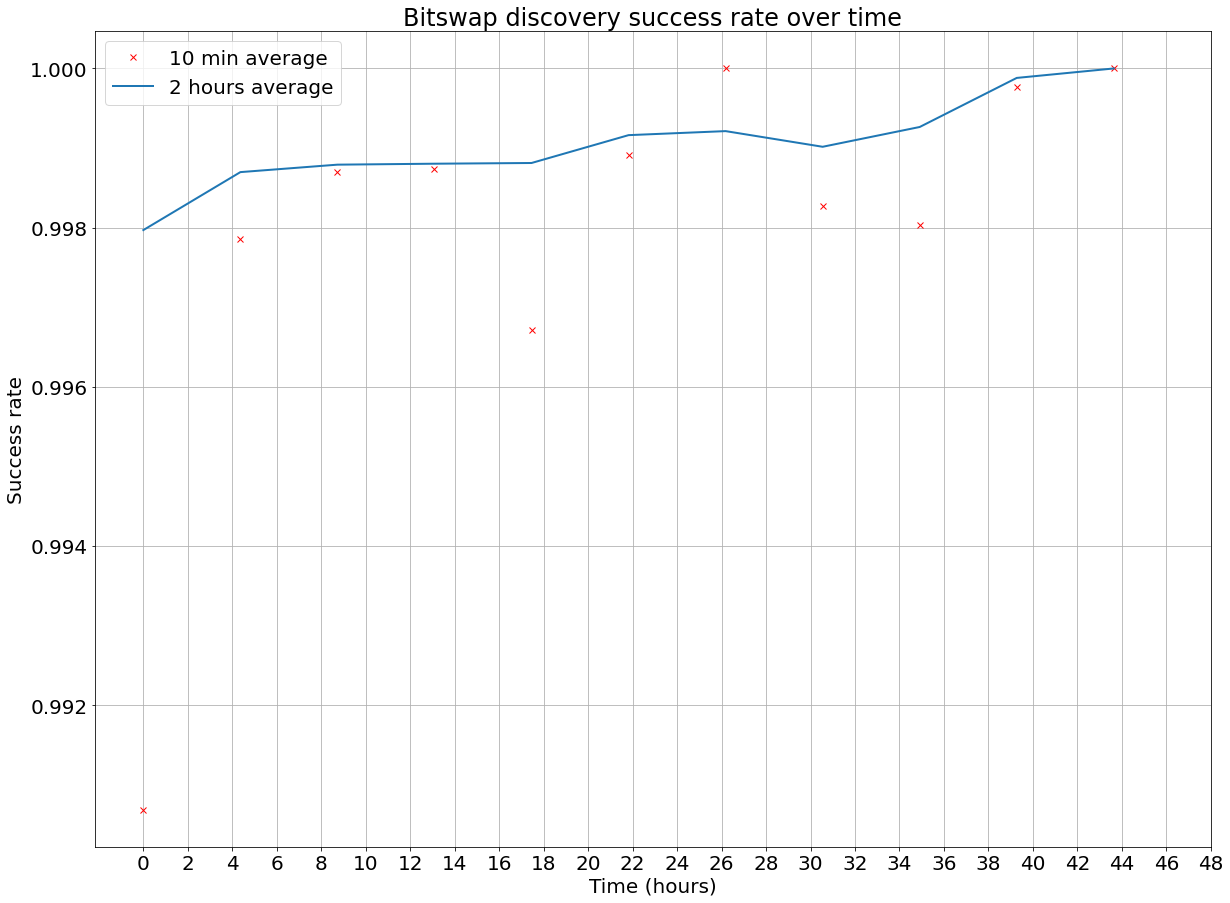

In [106]:
n_line_plot([line0, line1], labels=["10 min average", "2 hours average"],xticks_max=fortyeight_hours, title="Bitswap discovery success rate over time", xaxis_label="Time (hours)", yaxis_label="Success rate", filename="success-rate-over-time-"+experiment+".png")

## Success rate vs number of directly connected peers

In [107]:
def round_n_low(i, n):
    return n*int(i/n)
def round_n_high(i, n):
    return n*(int(i/n)+1)

In [108]:
min_npeers = 100000
max_npeers = 0
for r in reqs:
    if reqs[r]['type'] in [SUCCESS, FAILURE]:
        if reqs[r]['npeers'] > max_npeers:
            max_npeers = reqs[r]['npeers']
        if reqs[r]['npeers'] < min_npeers:
            min_npeers = reqs[r]['npeers']
min_npeers = round_n_low(min_npeers, 100)
max_npeers = round_n_high(max_npeers, 100)
range_npeers = max_npeers - min_npeers
print("min", min_npeers, "; max", max_npeers, "; range", range_npeers)

min 200 ; max 1700 ; range 1500


In [109]:
npeers_bins_number = 150
npeers_bins = {}
npeers_bucket_threshold = 100

In [110]:
for r in reqs:
    if reqs[r]['type'] in [SUCCESS, FAILURE]:
        b = int((reqs[r]['npeers']-min_npeers)/(range_npeers/npeers_bins_number))
        if b not in npeers_bins:
            npeers_bins[b] = [0, 0]
        if reqs[r]['type'] is SUCCESS:
            npeers_bins[b][0] += 1
        else:
            npeers_bins[b][1] += 1

In [111]:
npeers_bins_ratio = [npeers_bins[i][0]/(npeers_bins[i][0]+npeers_bins[i][1]) for i in range(npeers_bins_number) if i in npeers_bins and npeers_bins[i][0]+npeers_bins[i][1] > npeers_bucket_threshold]
xs = [i*(range_npeers/npeers_bins_number) for i in range(npeers_bins_number) if i in npeers_bins and npeers_bins[i][0]+npeers_bins[i][1] > npeers_bucket_threshold]

In [112]:
def simple_x_plot(xs, data, title=None, xaxis_label=None, yaxis_label=None, filename=None):
    # define fig style
    plt.rc('font', size=20)
    fig = plt.figure(figsize=(20,15), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)

    plt.plot(xs, data, 'rx', ms=10, mew=2)

    # set the grid
    plt.grid()

    # set title and axis labels
    if xaxis_label is not None:
        plt.xlabel(xaxis_label)
    if yaxis_label is not None:
        plt.ylabel(yaxis_label)
    if title is not None:
        plt.title(title)

    # export to file
    if filename is not None:
        plt.savefig(plots_folder+'/'+filename,
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

    # show the plot
    plt.show()

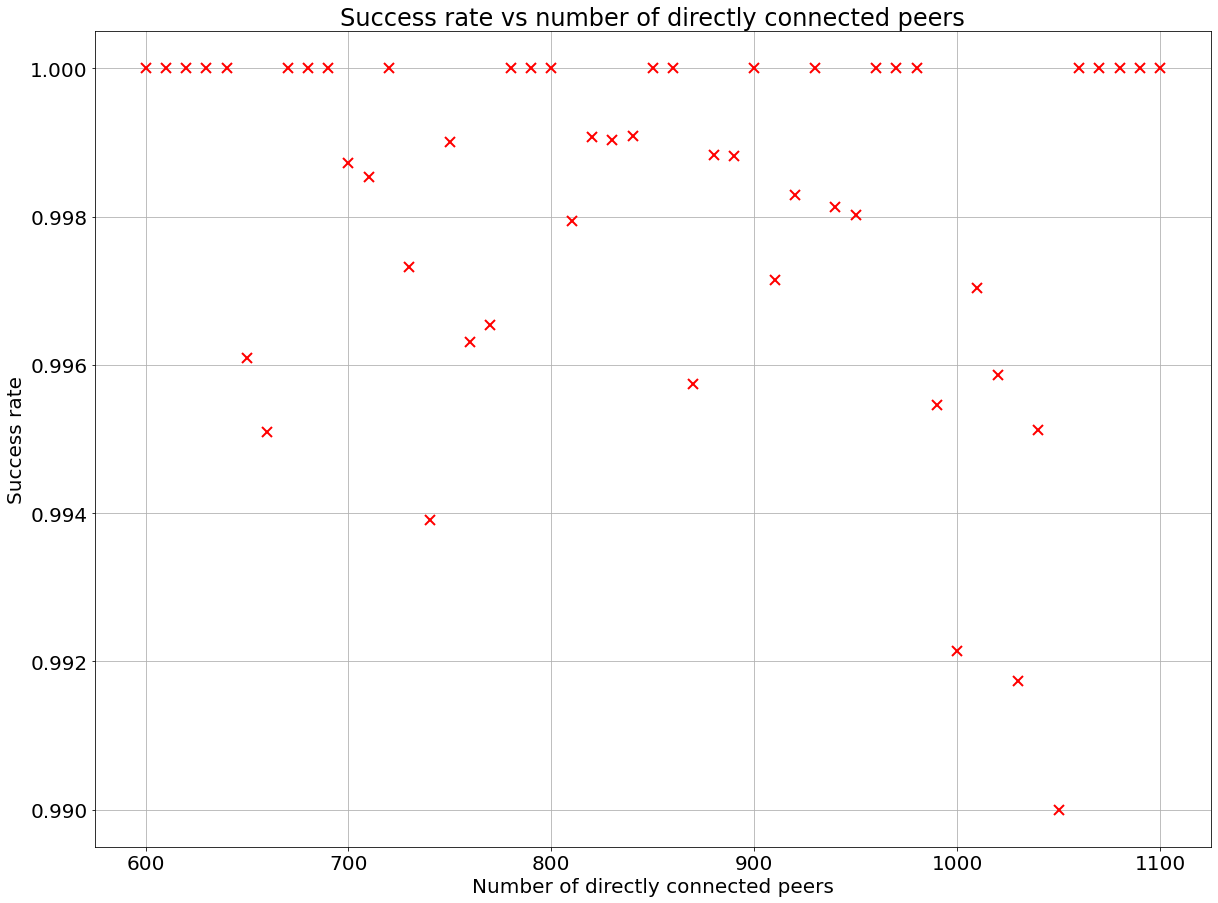

In [113]:
simple_x_plot(xs, npeers_bins_ratio, title="Success rate vs number of directly connected peers", xaxis_label="Number of directly connected peers", yaxis_label="Success rate", filename="success-rate-vs-npeers-"+experiment+".png")

In [114]:
string = ""
for cid in reqs:
    if reqs[cid]['type'] is SUCCESS:
        string += cid + ","

In [115]:
f = open("success-cids.txt", 'w')
f.write(string)
f.close()